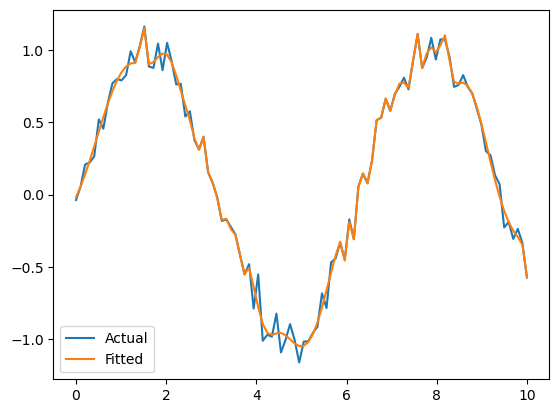

In [74]:
import numpy as np
from scipy.optimize import minimize

# Sample time series data
time = np.linspace(0, 10, 100)
data = np.sin(time) + np.random.normal(0, 0.1, len(time))

# Initial guess for Gaussian parameters
n_gaussians = 50
initial_means = np.linspace(time.min(), time.max(), n_gaussians)
initial_sigmas = np.full(n_gaussians, 1.0)
initial_amplitudes = np.full(n_gaussians, 1.0)
initial_params = np.concatenate([initial_means, initial_sigmas, initial_amplitudes])

# Gaussian function
def gaussian(t, mu, sigma, A):
    return A * np.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Sum of Gaussians
def sum_of_gaussians(params, t):
    means = params[:n_gaussians]
    sigmas = params[n_gaussians:2*n_gaussians]
    amplitudes = params[2*n_gaussians:]
    return sum(gaussian(t, mu, sigma, A) for mu, sigma, A in zip(means, sigmas, amplitudes))

# Loss function
def loss(params):
    fitted = sum_of_gaussians(params, time)
    return np.mean((data - fitted) ** 2)

# Optimize parameters
result = minimize(loss, initial_params, method='L-BFGS-B')
optimized_params = result.x

# Inference
fitted_data = sum_of_gaussians(optimized_params, time)

# Plot results
import matplotlib.pyplot as plt

plt.plot(time, data, label='Actual')
plt.plot(time, fitted_data, label='Fitted')
plt.legend()
plt.show()


sampling at [ 0.          1.42857143  2.85714286  4.28571429  5.71428571  7.14285714
  8.57142857 10.        ]
coverage per sample 0.8499999999999999
training on 86 samples


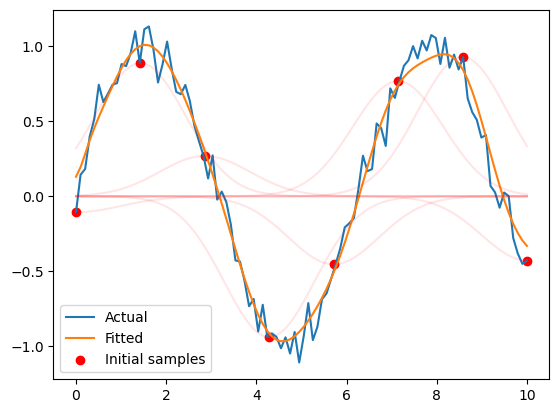

In [86]:
import numpy as np
from scipy.optimize import minimize

n_gaussians = 8
coverage = 0.85

# Sample time series data
time = np.linspace(0, 10, 100)
data = np.sin(time) + np.random.normal(0, 0.1, len(time))
timestep = time[1] - time[0]
# Initial guess for Gaussian parameters
samples = np.linspace(time.min(), time.max(), n_gaussians)
print(f"sampling at {samples}")

# area to the left and right of the sample, to train the gaussian
train_range_around_sample = (samples[1] - samples[0]) * coverage / 2
print(f"coverage per sample {train_range_around_sample * 2 / (samples[2] - samples[1])}") # must be equal to coverage

train_times = []
train_indexes = []
for i,t in enumerate(time):
    if any([sample - train_range_around_sample < t < sample + train_range_around_sample for sample in samples]):
        train_times.append(t)
        train_indexes.append(i)
train_times = np.array(train_times)
print(f"training on {len(train_times)} samples")
# get the value from data for each mean index
mean_indexes = [np.argmin(np.abs(time - mean)) for mean in samples]
sampled_values = data[mean_indexes]

initial_means = samples
initial_sigmas = np.full(n_gaussians, 1.0)
initial_amplitudes = sampled_values

initial_params = np.concatenate([initial_sigmas])

# Gaussian function
def gaussian(t, mu, sigma, A):
    return A * np.exp(-0.5 * ((t - mu) / sigma) ** 2)

# Sum of Gaussians
def sum_of_gaussians(params, t):
    means = samples
    sigmas = params[0:n_gaussians]#[n_gaussians:2*n_gaussians]
    amplitudes = sampled_values
    return sum(gaussian(t, mu, sigma, A) for mu, sigma, A in zip(means, sigmas, amplitudes))

# Loss function
def loss(params):
    fitted = sum_of_gaussians(params, train_times)
    return np.mean((data[train_indexes] - fitted) ** 2)

# Optimize parameters
result = minimize(loss, initial_params, method='L-BFGS-B')
optimized_params = result.x

# Inference
fitted_data = sum_of_gaussians(optimized_params, time)

# Plot results
import matplotlib.pyplot as plt

plt.plot(time, data, label='Actual')
plt.plot(time, fitted_data, label='Fitted')
plt.scatter(samples, sampled_values, color='red', label='Initial samples')
# plot all gaussians with 1 sigma
for mean, sigma, amplitude in zip(samples, initial_sigmas, sampled_values):
    plt.plot(time, gaussian(time, mean, sigma, amplitude), color='red', alpha=0.1)
plt.legend()
plt.show()

